# <img src="./assets/course-icon.png" style="height:50px;display:inline"> ECE 046211 - Technion - Deep Learning
---

#### <a href="https://taldatech.guthub.io"> Tal Daniel</a>

## Tutorial 03 - Optimization & Gradient Descent Algorithms
---

### <img src="https://img.icons8.com/bubbles/50/000000/checklist.png" style="height:50px;display:inline"> Agenda
---

* [Unimodal vs. Multimodal Optimization](#-Unimodal-vs.-Multimodal-Optimization)
* [Convexity](#-Convexity)
* [Optimality Conditions](#-Optimality-Conditions)
* [(Batch) Gradient Descent](#(Batch)-Gradient-Descent)
* [Stochastic Gradient Descent (Mini Batch Gradient Descent)](#Stochastic-Gradient-Descent-(Mini-Batch-Gradient-Descent))
* [GD Comparison Summary](#GD-Comparison-Summary)
* [The Learning Rate](#-The-Learning-Rate)
* [Example - (Multivariate) Linear Least Squares](#-Example---(Multivariate)-Linear-Least-Squares)
* [Learning Rate Scheduling (Annealing)](#-Learning-Rate-Scheduling-(Annealing))
    * [Learning Rate Scheduling in PyTorch](#-Learning-Rate-Scheduling-in-PyTorch)

* [Momentum & Nesterov Momentum](#-Momentum-&-Nesterov-Momentum)
    * [Momentum in PyTorch](#-Momentum-in-PyTorch)
* [Adaptive Learning Rate Methods](#-Adaptive-Learning-Rate-Methods)
    * [Adagrad](#-Adagrad)
        * [Adagrad in PyTorch](#-Adagrad-in-PyTorch)
    * [RMSprop](#-RMSprop)
        * [RMSprop in PyTorch](#-RMSprop-in-PyTorch)
    * [Adam - Adaptive Moment Estimation](#-Adam---Adaptive-Moment-Estimation)
        * [Adam in PyTorch](#-Adam-in-PyTorch)
* [Comparison Between Methods](#-Comparison-Between-Methods)
* [Recent Advances in Optimizers](#-Recent-Advances-in-Optimizers)
    * [AdaBelief](#-AdaBelief)
    * [MADGRAD](#-MADGRAD)
    * [Adan](#-Adan)

* [Recommended Videos](#-Recommended-Videos)
* [Credits](#-Credits)

In [1]:
# imports for the tutorial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
%matplotlib ipympl
# %matplotlib inline

# pytorch imports
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets

## <img src="https://img.icons8.com/cute-clipart/64/000000/minimum-value.png" style="height:50px;display:inline"> Unimodal vs. Multimodal Optimization
---
* **Unimodal** - only **one** optimum, that is, the *local* optimum is also global.

<center><img src="./assets/unimodal.jpg" style="height:200px"></center>

* **Multimodal** - more than one optimum.
  
<center><img src="./assets/multimodal.jpg" style="height:200px"></center>

Most search schemes are based on the assumption of **unimodal** surface. The optimum determined in such cases is called **local optimum design**.

The **global optimum** is the best of all *local optimum* designs.

### <img src="https://img.icons8.com/office/80/000000/statistics.png" style="height:50px;display:inline"> Convexity
---
* **Definition**: $$\forall x_1, x_2 \in X, \forall t \in [0,1]: $$ $$ f(tx_1 + (1-t)x_2) \leq tf(x_1) + (1-t)f(x_2) $$
  
<center><img src="./assets/convex_1.jpg" style="height:200px"></center>

<center><img src="./assets/convex_concave.gif" style="height:200px"></center>

<a href="http://mathworld.wolfram.com/Convex.html">Image Source</a>

* Convex functions are **unimodal**.
    * However, unimodal functions are not always convex, but they are usually still easy to optimize.
      
<center><img src="./assets/convex_2.jpg" style="height:200px"></center>

## <img src="https://img.icons8.com/dusk/64/000000/copyleft.png" style="height:50px;display:inline"> Optimality Conditions
---
* If $f: \mathbb{R}^d \to \mathbb{R}$ has *local* optimum at $x_0$ then $\nabla f(x_0) = 0$. 
    * $\nabla f(x_0)$ is also called **the gradient** at $x_0$.
* **The Hessian Matrix** : $H(f)(x)_{i,j} = \frac{\partial^2}{\partial x_i \partial x_j} f(x) \in \mathbb{R}^{d \times d}$
$$ H = \begin{bmatrix} \frac{\partial^2 f}{\partial x_1^2} & \frac{\partial^2 f}{\partial x_1 \partial x_2} & \cdots & \frac{\partial^2 f}{\partial x_1 \partial x_d}  \\ \frac{\partial^2 f}{\partial x_2 x_1} & \frac{\partial^2 f}{\partial x_2^2} & \cdots & \frac{\partial^2 f}{\partial x_2 \partial x_d}  \\ \vdots  & \vdots  & \ddots & \vdots  \\ \frac{\partial^2 f}{\partial x_d x_1} & \frac{\partial^2 f}{\partial x_d \partial x_2} & \cdots & \frac{\partial^2 f}{\partial x_d^2}  \end{bmatrix} $$

* If the **Hessian** matrix is:
    * **Positive Definite** (all eigenvalues *positive*) at $x_0 \rightarrow$ *local minimum*.
    * **Negative Definite** (all eigenvalues *negative*) at $x_0 \rightarrow$ *local maximum*.
    * Both **positive and negative** eigenvalues at $x_0 \rightarrow$ *saddle* point.
      <center><img src="./assets/saddle.jpg" style="height:100px"></center>
* Note: the Hessian matrix is symmetric if the second partial derivatives are continuous, but this is not always true (<a href="https://en.wikipedia.org/wiki/Symmetry_of_second_derivatives">Schwarz's theorem</a>).

## <img src="https://img.icons8.com/dusk/64/000000/treasure-map.png" style="height:50px;display:inline">(Batch) Gradient Descent
---
* Generic optimization algorithm capable of finding optimal solutions to a wide range of problems.
* The general idea is to tweak parameters **iteratively** to minimize a cost function.
* It measures the local gradient of the error function with regards to the parameter vector ($\theta$ or $w$), and it goes down in the direction of the descending gradient.
* **Once the gradient is zero - the minimum is reached (=convergence)**.

* **Pseudocode**:
    * **Require**: Learning rate $\alpha_k$
    * **Require**: Initial parameter vector $w$
    * **While** stopping criterion not met **do**
        * Compute gradient: $g \leftarrow \nabla_w f(x,w)$ 
        * Apply update: $w \leftarrow w - \alpha_k g$
        * $k \leftarrow k + 1$
    * **end while**

<center><img src="./assets/minimum.jpg" style="height:200px"></center>

* **Convergene**: When the cost function is *convex* and its slope does not change abruptly, (Batch) GD with a (small enough) *fixed* learning rate will eventually converge to the optimal solution (but the time is depndent on the rate).

<center><img src="./assets/gd_animation.gif" style="height:200px"></center>

<a href="https://commons.wikimedia.org/wiki/File:Gradient_descent.gif">Image Source</a>

### <img src="https://img.icons8.com/dusk/64/000000/waypoint-map.png" style="height:50px;display:inline">Stochastic Gradient Descent (Mini-Batch Gradient Descent)
---
* The main problem with (Batch) GD is that it uses the **whole** training set to compute the gradients. But what if that training set is huge or each sample has a very large number of features? Computing the gradient can take a very long time.
* *Stochastic* Gradient Descent on the other hand, samples just one instance randomly at every step and computes the gradients based on that single instance (remember the Perceptron algorithm?). This makes the algorithm much faster but due to its randomness, it is much less stable. Instead of steady decreasing untill reaching the minimum, the cost function will bounce up and down, **decreasing only on average**. With time, it will get *very close* to the minimum, but once it is there it will continue to bounce around!
    * When we have outliers, SGD may take us to undesirable areas.
* The final parameters are good but **not optimal**.

* When the cost function is very irregular, this bouncing can actually **help the algorithm escape local minima**, so SGD has better chance to find the *global* minimum.
* How to find optimal parameters using SGD?
    * **Reduce the learning rate gradually**: this is called *learning rate scheduling*.
        * But don't reduce too quickly or you will get stuck at a local minimum or even frozen!
* *Mini-Batch* Gradient Descent - same idea as SGD, but instead of one instance each step, $m$ samples.
    * Get a little bit closer to the minimum than SGD but a little harder to escape local minima.

* **Pseudocode**:
    * **Require**: Learning rate $\alpha_k$
    * **Require**: Initial parameter $w$
    * **While** stopping criterion not met **do**
        * Sample a minibatch of $m$ examples from the training set ($m=1$ for SGD)
        * Set $\{x_1,...,x_m,\}$ with corresponding targets $\{y_1,...,y_m\}$
        * Compute gradient: $g \leftarrow \frac{1}{m} \sum_{i=1}^m f'(x_i,w, y_i)$
        * Apply update: $w \leftarrow w - \alpha_k g$
        * $k \leftarrow k + 1$
    * **end while**

<center><img src="./assets/sgd.png" style="height:250px"></center>

<a href="https://towardsdatascience.com/gradient-descent-algorithm-and-its-variants-10f652806a3">Image Source</a>

#### GD Comparison Summary
---

| Method|Accuracy | Update Speed | Memory Usage |Online Learning |
|---|---|---|---|---|
| **Batch** Gradient Descent | Good | Slow |  High | No |
| **Stochastic** Gradient Descent |  Good (with softening) | Fast |  Low |  Yes |
| **Mini-Batch** Gradient Descent | Good | Medium | Medium | Yes (depends on the MB size) |


* **"Online"** - samples arrive while the algorithm runs (that is, when the algorithm starts running, not all samples exist)
* Note: all the Gradient Descent algorithms require **scaling** if the features are not within the same range!

#### Update Speed
---
* Assume: number of samples $M=100$ and we wish to train for $N=10$ epochs (iterating over all of the samples 10 times).
* Denote `batch_size` with $m$.
* `batch_size` and `num_epochs` are **hyper-parameters**: parameters that are chosen by the user prior to the training stage, they are not learned.

| Method|# Gradients Updates (=iterations) |
|-------|----------------------------------|
| **Batch** Gradient Descent, $m=100$| $\frac{M}{m} \cdot N = 1 * 10$ |
| **Stochastic** Gradient Descent, $m=1$ |  $\frac{M}{m} \cdot N =100 * 10 = 1000$ |
| **Mini-Batch** Gradient Descent, $m=10$ | $\frac{M}{m} \cdot N =10 * 10 = 100$ |

* The update speed affects how we tune the **learning rate**, which is also a hyper-parameter (usually, larger batches enable using higher learning rates).

#### Challenges
---
* Choosing a **learning rate**.
    * Defining **learning schedule**.
* Working with features of different scales (e.g. heights (cm), weights (kg) and age (scalar)).
* Avoiding **local minima** (or *suboptimal* minima).

###  <img src="https://img.icons8.com/fluent/96/000000/sample-rate.png" style="height:50px;display:inline"> The Learning Rate
---
* **Learning Rate** hyper-parameter - it is the size of step to be taken in each iteration.
    * Too *small* $\rightarrow$ the algorithm will have to go through many iterations to converge, which will take a long time.
    * Too *high* $\rightarrow$ might make the algorithm diverge as it may miss the minimum.
<center><img src="./assets/lr.png" style="height:250px"></center>

<a href="https://www.jeremyjordan.me/nn-learning-rate/">Image Source</a>

<center><img src="./assets/gd_converge_diverge.gif" style="height:300px"></center>

<a href="https://towardsai.net/p/machine-learning/analysis-of-learning-rate-in-gradient-descent-algorithm-using-python">Image Source</a>

### <img src="https://img.icons8.com/dusk/64/000000/classroom.png" style="height:50px;display:inline"> Example - (Multivariate) Linear Least Squares
---
* **Problem Formulation**
    * $y \in \mathbb{R}^N$ - vector of values.
    * $X \in \mathbb{R}^{N \times L}$ - data matrix with $N$ examples and *$L$ features*.
    * $w \in \mathbb{R}^L$ - the *parameters* to be learned, a **weight for each feature**.
* **Goal**: find $w$ that best fits the measurement y, that is, find a *weighted linear combination* of the feature vector to best fit the measurment $y$.
* Mathematiacally, the problem is:
$$\min_w f(w;x,y) = \min_w \sum_{i=1}^N||x_i w-y_i||^2 $$
* In vector form:
$$\min_w f(w;x,y) = \min_w ||Xw - Y||^2 $$

#### <img src="https://img.icons8.com/dusk/64/000000/idea.png" style="height:30px;display:inline">   (Multivariate) LLS - Analytical Solution
---
* Mathematically:
$$\min_w f(w;x,y) = \min_w ||Xw - Y||^2 = \min_w (Xw-Y)^T(Xw-Y)= \min_w (w^TX^TXw -2w^TX^TY + Y^TY)$$
* The derivative: 
$$\nabla_w f(w;x,y) = (X^TX + X^TX)w -2X^TY = 0 \rightarrow w=(X^TX)^{-1}X^TY $$ $$X^TX \in \mathbb{R}^{L \times L} $$

* Notice how the gradient is dependent on the features, which is why scaling them is important when applying gradient descent (however, scaling is not necessary if we use the closed-form solution, the least-squares solution).

In [2]:
# let's load the cancer dataset
dataset = pd.read_csv('./datasets/cancer_dataset.csv')
# print the number of rows in the data set
number_of_rows = len(dataset)
# reminder, the data looks like this
dataset.sample(10)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
474,911391,B,10.880,15.62,70.41,358.9,0.10070,0.10690,0.051150,0.015710,...,19.35,80.78,433.1,0.1332,0.38980,0.33650,0.07966,0.2581,0.10800,NaN
272,8910988,M,21.750,20.99,147.30,1491.0,0.09401,0.19610,0.219500,0.108800,...,28.18,195.90,2384.0,0.1272,0.47250,0.58070,0.18410,0.2833,0.08858,NaN
144,869254,B,10.750,14.97,68.26,355.3,0.07793,0.05139,0.022510,0.007875,...,20.72,77.79,441.2,0.1076,0.12230,0.09755,0.03413,0.2300,0.06769,NaN
315,894089,B,12.490,16.85,79.19,481.6,0.08511,0.03834,0.004473,0.006423,...,19.71,84.48,544.2,0.1104,0.04953,0.01938,0.02784,0.1917,0.06174,NaN
230,881972,M,17.050,19.08,113.40,895.0,0.11410,0.15720,0.191000,0.109000,...,24.89,133.50,1189.0,0.1703,0.39340,0.50180,0.25430,0.3109,0.09061,NaN
334,897374,B,12.300,19.02,77.88,464.4,0.08313,0.04202,0.007756,0.008535,...,28.46,84.53,544.3,0.1222,0.09052,0.03619,0.03983,0.2554,0.07207,NaN
266,8910251,B,10.600,18.95,69.28,346.4,0.09688,0.11470,0.063870,0.026420,...,22.94,78.28,424.8,0.1213,0.25150,0.19160,0.07926,0.2940,0.07587,NaN
21,8510824,B,9.504,12.44,60.34,273.9,0.10240,0.06492,0.029560,0.020760,...,15.66,65.13,314.9,0.1324,0.11480,0.08867,0.06227,0.2450,0.07773,NaN
224,8813129,B,13.270,17.02,84.55,546.4,0.08445,0.04994,0.035540,0.024560,...,23.60,98.84,708.8,0.1276,0.13110,0.17860,0.09678,0.2506,0.07623,NaN
347,89869,B,14.760,14.74,94.87,668.7,0.08875,0.07780,0.046080,0.035280,...,17.93,114.20,880.8,0.1220,0.20090,0.21510,0.12510,0.3109,0.08187,NaN


In [3]:
def plot_3d_lls(x, y, z, lls_sol, title=""):
    # plot
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z, label='Y')
    ax.scatter(x, y, lls_sol, label='Xw')
    ax.legend()
    ax.set_xlabel('Radius Mean')
    ax.set_ylabel('Area Mean')
    ax.set_zlabel('Perimeter Mean')
    ax.set_title(title)

In [4]:
def batch_generator(x, y, batch_size, shuffle=True):
    """
    This function generates batches for a given dataset x.
    """
    N, L = x.shape
    num_batches = N // batch_size
    batch_x = []
    batch_y = []
    if shuffle:
        # shuffle
        rand_gen = np.random.RandomState(0)
        shuffled_indices = rand_gen.permutation(np.arange(N))
        x = x[shuffled_indices, :]
        y = y[shuffled_indices, :]
    for i in range(N):
        batch_x.append(x[i, :])
        batch_y.append(y[i, :])
        if len(batch_x) == batch_size:
            yield np.array(batch_x).reshape(batch_size, L), np.array(batch_y).reshape(batch_size, 1)
            batch_x = []
            batch_y = []
    if batch_x:
        yield np.array(batch_x).reshape(-1, L), np.array(batch_y).reshape(-1, 1)

* **Pseudocode** for Linear Regression:
    * **Require**: Learning rate $\alpha_k$
    * **Require**: Initial parameter $w$
    * **While** stopping criterion not met **do**
        * Sample a minibatch of $m$ examples from the training set ($m=1$ for SGD)
        * Set $\tilde{X} = [x_1,...,x_m] $ with corresponding targets $\tilde{Y} = [y_1,...,y_m]$
        * Compute gradient: $g \leftarrow 2\tilde{X}^T\tilde{X}w - 2\tilde{X}^T \tilde{Y}$
        * Apply update: $w \leftarrow w - \alpha_k g$
        * $k \leftarrow k + 1$
    * **end while**

In [5]:
# multivaraite mini-batch gradient descent
X = dataset[['radius_mean', 'area_mean']].values
Y = dataset[['perimeter_mean']].values
# Scaling
X = (X - X.mean(axis=0, keepdims=True)) / X.std(axis=0, keepdims=True)
Y = (Y - Y.mean(axis=0, keepdims=True)) / Y.std(axis=0, keepdims=True)
N = X.shape[0]
batch_size = 10
num_batches = N // batch_size
print("total batches:", num_batches)

total batches: 56


In [7]:
num_epochs = 10
alpha_k = 0.001
batch_gen = batch_generator(X, Y, batch_size, shuffle=True)
L = X.shape[-1]
# initialize w
w = np.zeros((L, 1))
for i in range(num_epochs):
    for batch_i, batch in enumerate(batch_gen):
        batch_x, batch_y = batch
        if batch_i % 50 == 0:
            print("iter:", i, "batch:", batch_i, " w = ")
            print(w)
        gradient = 2 * batch_x.T @ batch_x @ w - 2 * batch_x.T @ batch_y
        w = w - alpha_k * gradient
    batch_gen = batch_generator(X, Y, batch_size, shuffle=True)

lls_sol = X @ w

iter: 0 batch: 0  w = 
[[0.]
 [0.]]
iter: 0 batch: 50  w = 
[[0.4391737 ]
 [0.41735388]]
iter: 1 batch: 0  w = 
[[0.45621431]
 [0.43296123]]
iter: 1 batch: 50  w = 
[[0.50458588]
 [0.46953377]]
iter: 2 batch: 0  w = 
[[0.50659246]
 [0.46976394]]
iter: 2 batch: 50  w = 
[[0.51664408]
 [0.46913792]]
iter: 3 batch: 0  w = 
[[0.51715596]
 [0.46786206]]
iter: 3 batch: 50  w = 
[[0.52339741]
 [0.46367398]]
iter: 4 batch: 0  w = 
[[0.52374047]
 [0.4622501 ]]
iter: 4 batch: 50  w = 
[[0.5295512 ]
 [0.45779193]]
iter: 5 batch: 0  w = 
[[0.52985556]
 [0.456353  ]]
iter: 5 batch: 50  w = 
[[0.53556725]
 [0.45194588]]
iter: 6 batch: 0  w = 
[[0.53584598]
 [0.45050492]]
iter: 6 batch: 50  w = 
[[0.54149192]
 [0.44617918]]
iter: 7 batch: 0  w = 
[[0.54174661]
 [0.44473749]]
iter: 7 batch: 50  w = 
[[0.54733087]
 [0.44049501]]
iter: 8 batch: 0  w = 
[[0.54756198]
 [0.43905271]]
iter: 8 batch: 50  w = 
[[0.55308576]
 [0.43489257]]
iter: 9 batch: 0  w = 
[[0.55329364]
 [0.43344969]]
iter: 9 batch: 50  

w:
[[0.55894282]
 [0.42792729]]


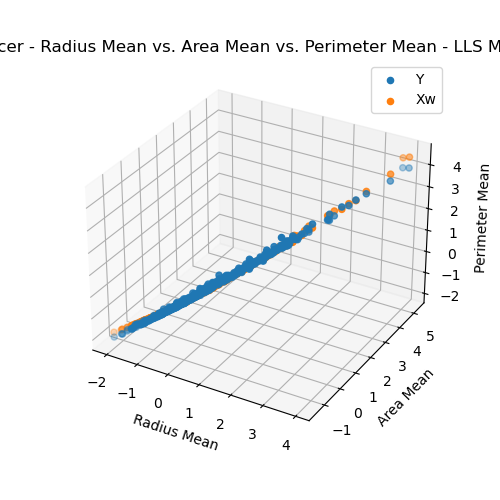

In [8]:
# plot
plot_3d_lls(X[:,0], X[:, 1], Y, lls_sol, "Breast Cancer - Radius Mean vs. Area Mean vs. Perimeter Mean - LLS Mini-Batch GD")
print("w:")
print(w)

## <img src="https://img.icons8.com/clouds/100/000000/stopwatch.png" style="height:50px;display:inline"> Learning Rate Scheduling (Annealing)
---
* When training deep networks, it is usually helpful to anneal (gradually change the rate) the learning rate over time. 
    * **Physics intuition**: with a high learning rate, the system contains too much *kinetic energy* and the parameter vector bounces around chaotically, unable to settle down into deeper, but narrower parts of the loss function. 
* Knowing when to decay the learning rate can be tricky: decay it **slowly** and you’ll be wasting computation bouncing around chaotically with little improvement for a long time. But decay it **too aggressively** and the system will cool too quickly, unable to reach the best position it can. 
* There are three common types of implementing the learning rate decay: step deacy, exponential decay and $1/t$ decay.
    * Recently, *cyclic* learning schedulers, such as <a href="https://www.kaggle.com/residentmario/one-cycle-learning-rate-schedulers">One-cycle learning rate scheduler</a> or *cosine* scheduling, have been gaining popularity as well.

* **(Multi) Step decay**: Reduce the learning rate by some factor every few epochs. 
    * Typical values might be reducing the learning rate by a half every 5 epochs, or by 0.1 every 20 epochs. These numbers depend heavily on the type of problem and the model. 
    * One heuristic you may see in practice is to watch the *validation error* while training with a fixed learning rate, and reduce the learning rate by a constant (e.g. 0.5) whenever the validation error stops improving.

* **Exponential decay**: has the mathematical form: $$\alpha = \alpha_0 \exp(-kt),$$ where $\alpha_0, k$ are hyperparameters and $t$ is the iteration number (but you can also use units of epochs).
    * $\alpha_0$ is the initial learning rate.
    * $k$ is also referred to as the `gamma` ($\gamma$) hyperparameter.

* **1/t decay**: has the mathematical form: $$\alpha = \frac{\alpha_0}{1+kt},$$ where $\alpha_0,k$ are hyperparameters and $t$ is the iteration number.

* **Cosine annealing**: has the mathematical form: $$ \alpha = \alpha_{min} +\frac{1}{2}(\alpha_0 - \alpha_{min})\left(1 +\cos\left(\frac{t}{t_{max}}\pi\right) \right), $$ where $\alpha_{min}$ is the minimum learning rate (deafult is 0) and $t_{max}$ is number of iterations to perform a cycle.

* In practice, we usually find that the **step decay** is slightly preferable because the hyperparameters it involves (the fraction of decay and the step timings in units of epochs) are more interpretable than the hyperparameter $k$. 
* Lastly, if you can afford the computational budget, you can try a slower decay and train for a longer time.

### <img src="https://img.icons8.com/cotton/64/000000/olympic-torch.png" style="height:50px;display:inline"> Learning Rate Scheduling in PyTorch
---
* We will use learning rate scheduling to train the neural network models later in the course.
* PyTorch offers several schedulers which can be found <a href="https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate">here</a>.
* A typical workflow with schedulers (learning rate scheduling should be applied **after** optimizer’s update):
<code>
scheduler = ...
for epoch in range(100):
    train(...)
    validate(...)
    scheduler.step()
</code>

* <a href="https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html#torch.optim.lr_scheduler.StepLR">`torch.optim.lr_scheduler.StepLR`</a>
* <a href="https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.MultiStepLR.html#torch.optim.lr_scheduler.MultiStepLR">`torch.optim.lr_scheduler.MultiStepLR`</a>
* <a href="https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ExponentialLR.html#torch.optim.lr_scheduler.ExponentialLR">`torch.optim.lr_scheduler.ExponentialLR`</a>
* <a href="https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingLR.html#torch.optim.lr_scheduler.CosineAnnealingLR">`torch.optim.lr_scheduler.CosineAnnealingLR`</a>
* <a href="https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.OneCycleLR.html#torch.optim.lr_scheduler.OneCycleLR">`torch.optim.lr_scheduler.OneCycleLR`</a>
* <a href="https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CyclicLR.html#torch.optim.lr_scheduler.CyclicLR">`torch.optim.lr_scheduler.CyclicLR`</a>
* And more...

#### Reducing LR on Plateau
---
* Reduce learning rate when a metric has stopped improving. Usually the validation accuracy.
* Models often benefit from reducing the learning rate by a factor of 2-10 once learning does not improve. 
* This scheduler reads a metrics quantity and if no improvement is seen for a `patience` number of epochs, the learning rate is reduced.
* In PyTorch: <a href="https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html#torch.optim.lr_scheduler.ReduceLROnPlateau">`torch.optim.lr_scheduler.ReduceLROnPlateau`</a>.

<center><img src="./assets/tut_opt_reduce_lr.png" style="height:300px"></center>

* <a href="https://www.researchgate.net/publication/339252130_Exponential_Step_Sizes_for_Non-Convex_Optimization">Exponential Step Sizes for Non-Convex Optimization, Li et al. 2020</a>.
* Plots of the train loss and test accuracy for training a 20-layer Residual Network to do image classification on CIFAR-10.
* The number of milestones in the legend denotes how many times we can choose to decrease the step size during training.

## <img src="https://img.icons8.com/clouds/100/000000/hill-descent-control.png" style="height:50px;display:inline"> Momentum & Nesterov Momentum
---
* Gradient descent is simple and has many virtues, but **speed** is not one of them.
* For a step-size small enough, gradient descent makes a monotonic improvement at every iteration. It should always converge (sometimes to a local minimum).
* **Momentum update** is another optimization approach that *almost always* enjoys better convergence rates in deep networks. 
    * It can be seen as a **"global" (equally for all parameters) adaptive learning rate**.

* This update can be motivated from a physical perspective of the optimization problem. In particular, the loss can be interpreted as the height of a *hilly terrain*.
    *  Initializing the parameters with random numbers is equivalent to setting a particle with zero initial velocity at some location. The optimization process can then be seen as equivalent to the process of simulating the parameter vector (i.e. a particle) as rolling on the landscape.
    * Since the force on the particle is related to the gradient of potential energy (i.e. $F=−\nabla U$ ), the force felt by the particle is precisely the (negative) gradient of the loss function. 
    * Moreover, $F=ma$ so the (negative) gradient is in this view proportional to the acceleration of the particle.
    * The physics view suggests an update in which the gradient only directly influences the velocity (and maintains information about the acceleration), which in turn has an effect on the position.

* Momentum proposes the following tweak to gradient descent, giving gradient descent **a short-term memory**: $$ z^{k+1} = \beta z^k -\alpha\nabla f(w^k) $$ $$ w^{k+1} = w^k + z^{k+1} $$
    * $\alpha$ is the learning rate.

* When $\beta = 0$ , we recover gradient descent. But for $\beta = 0.99$ (sometimes 0.999, if things are really bad), this appears to be the boost we need. Our iterations regain that speed and boldness it lost, speeding to the optimum with a renewed energy.
* $\beta$ is a variable that is sometimes called *momentum*.
* Effectively, this variable **damps the velocity and reduces the kinetic energy of the system**, or otherwise the particle would never come to a stop at the bottom of a hill.
* With Momentum update, the parameter vector will build up velocity in any direction that has consistent gradient.
* <a href="https://distill.pub/2017/momentum/">Momentum Demo</a>
* Note: Momentum usually works in **larger batches** and may break in smaller batches.

<center><img src="./assets/sgd-mom.png" style="height:250px"></center>

* <a href="https://dominikschmidt.xyz/nesterov-momentum">Image Source</a>

#### Nesterov Momentum
---
* Nesterov Momentum is a slightly different version of the momentum update that has gained popularity. 
* It enjoys stronger theoretical convergence guarantees for **convex functions** and in practice it also consistenly works slightly better than standard momentum.
* The core idea behind Nesterov momentum is that when the current parameter vector is at some position $x$, then looking at the momentum update above, we know that the momentum term alone (i.e. ignoring the second term with the gradient) is about to nudge the parameter vector by $\beta * z_k$. 
* Therefore, if we are about to compute the gradient, we can treat the future approximate position $x + \beta * z_k$ as a **“lookahead”** - this is a point in the vicinity of where we are soon going to end up. 
* Hence, it makes sense to compute the **gradient** at $x + \beta * z_k$ instead of at the “old/stale” position $x$, since while the gradient term always points in the right direction, the momentum term may not. 
* If the momentum term points in the wrong direction or overshoots, the gradient can still "go back" and correct it in the same update step.

* **Nesterov Momentum**: $$ z^{k+1} = \beta z^k -\alpha \nabla f(w^k +\beta z^k) $$ $$ w^{k+1} = w^k + z^{k+1} $$

<center><img src="./assets/sgd-nag.png" style="height:250px"></center>

* <a href="https://dominikschmidt.xyz/nesterov-momentum">Image Source</a>

### <img src="https://img.icons8.com/cotton/64/000000/olympic-torch.png" style="height:50px;display:inline"> Momentum in PyTorch
---
* `torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)`

In [ ]:
# simple optimizer and lr scheduling example
# courtesy of: deeplearningwizard.com/deep_learning/boosting_models_pytorch/lr_scheduling/

from torch.optim.lr_scheduler import ReduceLROnPlateau

'''
STEP 1: LOADING DATASET
'''

train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

'''
STEP 2: MAKING DATASET ITERABLE
'''

batch_size = 100
n_iters = 6000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

'''
STEP 3: CREATE MODEL CLASS
'''
class SimpleModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleModel, self).__init__()
        # Linear function
        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        # Non-linearity
        self.relu = nn.ReLU()
        # Linear function (readout)
        self.fc2 = nn.Linear(hidden_dim, output_dim)  

    def forward(self, x):
        # Linear function
        out = self.fc1(x)
        # Non-linearity
        out = self.relu(out)
        # Linear function (readout)
        out = self.fc2(out)
        return out
'''
STEP 4: INSTANTIATE MODEL CLASS AND DEVICE
'''
input_dim = 28 * 28
hidden_dim = 100
output_dim = 10
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = SimpleModel(input_dim, hidden_dim, output_dim).to(device)

'''
STEP 5: INSTANTIATE LOSS CLASS
'''
criterion = nn.CrossEntropyLoss()


'''
STEP 6: INSTANTIATE OPTIMIZER CLASS
'''
learning_rate = 0.1

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)

'''
STEP 7: INSTANTIATE STEP LEARNING SCHEDULER CLASS
'''
# lr = lr * factor 
# mode='max': look for the maximum validation accuracy to track
# patience: number of epochs - 1 where loss plateaus before decreasing LR
        # patience = 0, after 1 bad epoch, reduce LR
# factor = decaying factor
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=0, verbose=True)

'''
STEP 7: TRAIN THE MODEL
'''
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Send images and labels to device
        images = images.view(-1, 28 * 28).to(device)
        labeles = labels.to(device)

        # Forward pass to get output/logits
        outputs = model(images)

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                # Send images and labels to device
                images = images.view(-1, 28 * 28).to(device)
                labeles = labels.to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += labels.size(0)

                # Total correct predictions
                # Without .item(), it is a uint8 tensor which will not work when you pass this number to the scheduler
                correct += (predicted == labels).sum().item()

            accuracy = 100 * correct / total

            # Print Loss
            # print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.data[0], accuracy))

    # Decay Learning Rate, pass validation accuracy for tracking at every epoch
    print('Epoch {} completed'.format(epoch))
    print('Loss: {}. Accuracy: {}'.format(loss.item(), accuracy))
    print('-' * 20)
    scheduler.step(accuracy)  # accuracy is used to track down a plateau

## <img src="https://img.icons8.com/dusk/64/000000/wired-network.png" style="height:50px;display:inline"> Adaptive Learning Rate Methods
---
**Adapative learning methods compute individual learning rates for different parameters.**
Previously, we performed an update for all parameters $w$ (or $\theta$) at once as every parameter $w_i$ used the same learning rate $\alpha$.


Popular algorithms include: AdaGrad, Rprop, RMSprop, Adam and more...

### <img src="https://img.icons8.com/cotton/64/000000/olympic-torch.png" style="height:50px;display:inline"> Optimizers in PyTorch
---
All optimizers mentioned in this tutorial and more can be imported from the `torch.optim` library. Check out the full list of available optimizers in <a href="https://pytorch.org/docs/stable/optim.html#algorithms">this link</a>.

## <img src="https://img.icons8.com/plasticine/100/000000/horizontal-settings-mixer.png" style="height:50px;display:inline"> Adagrad
---
* **Adagrad**: one of the first adaptive learning rate algorithm, with the basic idea of adapting the learning rate to the parameters by performing smaller updates (i.e. low learning rates) for parameters associated with *frequently* occurring features, and larger updates (i.e. high learning rates) for parameters associated with *infrequent* features.
    * For this reason, it works well with *sparse* data.
* Adagrad uses a different learning rate for every parameter $w_i$ at every time step $k$.
* We denote:
    * $\alpha$ - the learning rate.
    * $g_k = \nabla f(w^k)$, the gradient at time step $k$, and $g_{i, k}$ the *partial* derivative w.r.t. the parameter $w_i$ at time step $k$.
    * $G_k \in \mathbb{R}^{d \times d}$ - a *diagonal* matrix, where each element $G_{i,i}^k$ is the **sum of squares of the gradients w.r.t $w_i$ up to time step $k$**, $G_{i, i}^k = \sum_{j=1}^k g_{i, j}^2$.
    * $\epsilon$, a "smoothing" term that prevents division by zero, deafult is $10^{-8}$, but can range from $10^{-4}$ to $10^{-8}$.

* The Adagrad update rule: $$ w_i^{k+1} = w_i^k -\frac{\alpha}{\sqrt{G_{i,i}^k + \epsilon}} \cdot g_{i, k} $$
* Interestingly, without the square root operation, the algorithm performs much worse.
* In vectorized form, we use the matrix-vector product $\odot$ between $G_k$ and $g_k$: $$ w^{k+1} = w^k -\frac{\alpha}{\sqrt{G^k + \epsilon}} \odot g_{k} $$

* Adagrad eliminates, or alleviates, the need to manually tune the learning rate, which is nice. 
* Most implementations use a default value of 0.01 for the learning rate.
* However, its main **weakness** is the accumulation of the squared gradients (a positive quantity) in the denominator which keeps growing during training and causes the learning rate to **shrink** and eventually become very small, at which point the algorithm doesn't acquire additional knowledge.

### <img src="https://img.icons8.com/cotton/64/000000/olympic-torch.png" style="height:50px;display:inline"> Adagrad in PyTorch
---
* `torch.optim.Adagrad(model.parameters(), lr=learning_rate, initial_accumulator_value=0, eps=1e-10)`

## <img src="https://img.icons8.com/cute-clipart/64/000000/square-root.png" style="height:50px;display:inline"> RMSprop
---
* **RMSprop**: an unpublished (no official paper) optimization algorithm designed for neural networks, first proposed by Geoffrey Hinton in <a href="https://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf">lecture 6 (slide 29)</a> of the online course “Neural Networks for Machine Learning”.
* The RMSProp update adjusts the **Adagrad** method in a very simple way in an attempt to reduce its aggressive, monotonically decreasing learning rate.
* In particular, it uses **a moving average of squared gradients** instead.
* We denote:
    * $\alpha$ - the learning rate.
    * $g_k = \nabla f(w^k)$
    * $\mathbb{E}[g^2]$ - moving average of squared gradients (stored in a cache with squared gradients from previous iterations).
    * $\beta$ - moving average parameter (good default value — 0.9).

* The RMSprop update rule: $$ \mathbb{E}[g^2]_{k+1} = \beta\mathbb{E}[g^2]_k + (1-\beta)g_k^2 $$ $$ w^{k+1} = w^k -\frac{\alpha}{\sqrt{\mathbb{E}[g^2]_{k+1}}}\nabla f(w^k) $$
* The learning rate is adapted by dividing by the root of squared gradient, but since we only have the estimate of the gradient on the current mini-batch, we need instead to use the moving average of it.

### <img src="https://img.icons8.com/cotton/64/000000/olympic-torch.png" style="height:50px;display:inline"> RMSprop in PyTorch
---
* `torch.optim.RMSprop(model.parameters(), lr=learning_rate, alpha=0.99)`
    * `alpha` is $\beta$ from the equations above, the moving average parameter.

## <img src="https://img.icons8.com/clouds/100/000000/heat-map.png" style="height:50px;display:inline"> Adam - Adaptive Moment Estimation
---
* **Adam**: another optimization method that computes adaptive learning rates for each parameter. 
* Adam combines the advantages of Adagrad, RMSprop and Momentum: It uses the **squared gradients to scale the learning rate** like RMSprop and it takes advantage of momentum by using **moving average of the gradient instead of the gradient itself** like SGD with momentum.
* In addition to storing an exponentially decaying average of past **squared gradients** like Adadelta and RMSprop, Adam also keeps an exponentially decaying average of past **gradients** similar to momentum.
    * Whereas momentum can be seen as a ball running down a slope, Adam behaves like a heavy ball with friction, and thus prefers flat minima in the error surface.


* We denote:
    * $\alpha$ - the learning rate.
    * $m$ - moving average of gradients. Estimates the first moment (mean) of the gardients.
    * $v$ - moving average of squared gradients. Estimates the second momemnt (variance) of the gradients.
    * $\beta_1$ - moving average parameter for $m$ (default: 0.9).
    * $\beta_2$ - moving average parameter for $v$ (default: 0.999).

* The Adam update rule: $$ \mathbb{E}[g]_{k+1} = m_{k+1} = \beta_1 m_k + (1-\beta_1)\nabla f(w^k) = \beta_1 m_k + (1-\beta_1)g_k $$  $$ \mathbb{E}[g^2]_{k+1} = v_{k+1} = \beta_2 v_k + (1-\beta_2)(\nabla f(w^k))^2 = \beta_2 v_k + (1-\beta_2)g^2_k $$ Then, we use an **unbiased** estimation: $$ \hat{m}_{k+1} = \frac{m_{k+1}}{1 -\beta_1^{k+1}} $$ $$ \hat{v}_{k+1} = \frac{v_{k+1}}{1 -\beta_2^{k+1}} $$ (the $\beta$'s are taken with the power of the current iteration) $$ w^{k+1} = w^k -\frac{\alpha}{\sqrt{\hat{v}_{k+1}} +\epsilon}\hat{m}_{k+1} $$

* $\epsilon$, a "smoothing" term that prevents diviosn by zero, deafult's is $10^{-8}$, but can range from $10^{-4}$ to $10^{-8}$. Note that the default $\epsilon = 1e-8$ might be sub-optimal for various tasks, and thus it is recommended to test lower values as well.
    *  <a href="https://arxiv.org/abs/2011.02150">EAdam Optimizer: How ε Impact Adam</a> - Wei Yuan, Kai-Xin Gao.
    *  <a href="http://zna.do/epsilon">ε, a A Nuisance No More</a> - Zack Nado.

### <img src="https://img.icons8.com/cotton/64/000000/olympic-torch.png" style="height:50px;display:inline"> Adam in PyTorch
---
* `torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999))`
    
If you want to use weight decay (i.e., $L_2$ regularization on the weights), use `AdamW`, which adds a fix to the update rule to account for the weight regularization.

* <a href="https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html#torch.optim.AdamW">`torch.optim.AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), weight_decay=0.01)`</a>

## <img src="https://img.icons8.com/doodle/96/000000/scales--v1.png" style="height:50px;display:inline"> Comparison Between Methods
---
<center><img src="./assets/loss_conturs_all_grad_w_adam.gif" style="height:300px"></center>

* Contours of a loss surface and time evolution of different optimization algorithms. 
* Notice the "overshooting" behavior of **momentum-based methods**, which makes the optimization look like a ball rolling down the hill.

* <a href="https://github.com/ilguyi/optimizers.numpy">Image Source</a>

<center><img src="./assets/saddle_point_all_grad.gif" style="height:250px"></center>

* A visualization of a **saddle point** in the optimization landscape, where the curvature along different dimension has different signs (one dimension curves up and another down). 
* Notice that SGD has a very hard time breaking symmetry and gets *stuck* on the top. 
* Conversely, algorithms such as RMSprop will see very low gradients in the saddle direction. Due to the denominator term in the RMSprop update, this will increase the effective learning rate along this direction, helping RMSProp proceed.

* Image credit: <a href="https://twitter.com/alecrad">Alec Radford</a>

## <img src="https://img.icons8.com/bubbles/50/new.png" style="height:50px;display:inline"> Recent Advances in Optimizers
---
* Adam, "the king of optimizers", has been the go-to optimizer for some time now, and while there were several attempts to dethrone it, there was not a major breakthrough in the optimizers literature to replace it, and Adam is still widely used in all major deep learning domains.
* However, several notable recent works have proposed alternatives that show great promise as candidates to replace Adam, which we cover below.

## <img src="https://img.icons8.com/cute-clipart/64/pray.png" style="height:50px;display:inline"> AdaBelief
---
* Introduced in <a href="https://arxiv.org/abs/2010.07468">AdaBelief Optimizer: Adapting Stepsizes by the Belief in Observed Gradients</a> - Zhuang et al., NeurIPS 2020.
* **Motivation**: achieve three goals -- fast convergence as in adaptive methods, good generalization as in SGD, and training stability.
* **Main idea**: adapt the step-size according to the "belief" in the current gradient direction -- the moving average (EMA) of the noisy gradient serves as the prediction of the gradient at the next time step; take a small step if the prediction and current gradient have a large difference and otherwise take a large step.
  
<center><img src="./assets/adabelief_algo.png" style="height:250px"></center>

<center><img src="./assets/adabelief2.gif" style="height:300px"></center>


* <a href="https://juntang-zhuang.github.io/adabelief/">Website</a>, <a href="https://github.com/juntang-zhuang/Adabelief-Optimizer">PyTorch Code</a>

## <img src="https://img.icons8.com/external-bzzricon-smooth-bzzricon-studio/64/external-mad-puppy-bzzricon-smooth-bzzricon-smooth-bzzricon-studio.png" style="height:50px;display:inline"> MADGRAD
---
* Introduced in <a href="https://arxiv.org/abs/2101.11075">Adaptivity without Compromise: A Momentumized, Adaptive, Dual Averaged Gradient Method for Stochastic Optimization</a> - Aaron Defazio and Samy Jelassi (META AI Research), JMLR 2022.
* **Motivation**: combine adaptivity with strong generalization performance.
* **Main idea**: based the dual averaging formulation of AdaGrad, combined with momentum and adaptivity to achieve the generalization performance of SGD and the fast convergence of Adam. 
  
<center><img src="./assets/madgrad_algo.PNG" style="height:250px"></center>

* <a href="https://madgrad.readthedocs.io/en/latest/">Website</a>, <a href="https://github.com/facebookresearch/madgrad">PyTorch Code</a>.
    * Notes: GPU-only. Typically, the same learning rate schedule that is used for SGD or Adam may be used. MADGRAD requires less weight decay than other methods, often as little as zero. Momentum values used for SGD or Adam’s $\beta_1$ should work here.

## <img src="https://img.icons8.com/external-goofy-color-kerismaker/96/external-Seesaw-momentum-science-goofy-color-kerismaker.png" style="height:50px;display:inline"> Adan
---
* Introduced in <a href="https://arxiv.org/abs/2208.06677">Adan: Adaptive Nesterov Momentum Algorithm for Faster Optimizing Deep Models</a> - Xie et al., 2022.
* **Motivation**: improve the deep learning model training speed by utilizing an accurate and stable estimation of the gradient moments.
* **Main idea**: a new Nesterov momentum estimation (NME) method, which avoids the extra overhead of computing gradient at the extrapolation point and used to estimate the gradient's first-order and second-order moments in adaptive gradient algorithms for convergence acceleration.
  
<center><img src="./assets/adan_algo.PNG" style="height:300px"></center>

<center><img src="./assets/adan_table.PNG" style="height:300px"></center>

* <a href="https://github.com/sail-sg/Adan">PyTorch Code</a>.
    * Notes: Adan has a slightly higher GPU memory cost than Adam/AdamW on a single node.

### <img src="https://img.icons8.com/bubbles/50/000000/video-playlist.png" style="height:50px;display:inline"> Recommended Videos
---
#### <img src="https://img.icons8.com/cute-clipart/64/000000/warning-shield.png" style="height:30px;display:inline"> Warning!
* These videos do not replace the lectures and tutorials.
* Please use these to get a better understanding of the material, and not as an alternative to the written material.

#### Video By Subject

* Gradient Descent - <a href="https://www.youtube.com/watch?v=sDv4f4s2SB8">Gradient Descent, Step-by-Step</a>
    * <a href="https://www.youtube.com/watch?v=jc2IthslyzM">Mathematics of Gradient Descent - Intelligence and Learning</a>
* Stochastic Gradient Descent - <a href="https://www.youtube.com/watch?v=vMh0zPT0tLI">Stochastic Gradient Descent, Clearly Explained</a>
* Momentum - <a href="https://www.youtube.com/watch?v=k8fTYJPd3_I">Gradient Descent With Momentum (C2W2L06)</a>
* RMSProp - <a href="https://www.youtube.com/watch?v=_e-LFe_igno">RMSProp (C2W2L07)</a>
* Adam - <a href="https://www.youtube.com/watch?v=JXQT_vxqwIs">Adam Optimization Algorithm (C2W2L08)</a>
* Learning Rate Decay - <a href="https://www.youtube.com/watch?v=QzulmoOg2JE">Learning Rate Decay (C2W2L09)</a>
* Momentum, Adagrad, RMSProp, Adam - <a href="https://www.youtube.com/watch?v=gmwxUy7NYpA">UC Berkeley, STAT 157 - Momentum, Adagrad, RMSProp, Adam</a>
* AdaBelief - <a href="https://www.youtube.com/watch?v=oGH7dmwvuaY">AdaBelief Optimizer: Theory and Practical Guidelines</a>

## <img src="https://img.icons8.com/dusk/64/000000/prize.png" style="height:50px;display:inline"> Credits
---
* Icons made by <a href="https://www.flaticon.com/authors/becris" title="Becris">Becris</a> from <a href="https://www.flaticon.com/" title="Flaticon">www.flaticon.com</a>
* Icons from <a href="https://icons8.com/">Icons8.com</a> - https://icons8.com
* Datasets from <a href="https://www.kaggle.com/">Kaggle</a> - https://www.kaggle.com/
* Examples and code snippets were taken from <a href="http://shop.oreilly.com/product/0636920052289.do">"Hands-On Machine Learning with Scikit-Learn and TensorFlow"</a>
* <a href="https://cs231n.github.io/neural-networks-3/">CS231n: Convolutional Neural Networks for Visual Recognition</a>
* <a href="https://www.deeplearningwizard.com/deep_learning/boosting_models_pytorch/lr_scheduling/">Deep Learning Wizard -Learning Rate Scheduling</a>
* <a href="https://dominikschmidt.xyz/nesterov-momentum">Understanding Nesterov Momentum (NAG)</a>
* <a href="https://ruder.io/optimizing-gradient-descent/">Sebastian Ruder - An overview of gradient descent optimization algorithms</a>